# E-Flux2 (08302023 data + StrainDesign) 
The purpose of the notebook is to run flux balance analysis to find the set of genome scale fluxes that maximizes biomass production.<br><br>
The flux balance analysis results are then compared to reaction rates determined by 13C-metabolic flux analysis (13C-MFA). <br><br>
The results of this notebook will be compared to transcript constained genome scale model flux results via E-Flux2. <br><br>
This notebook looks at glucose, glycerol, acetate, and oleic acid as sole carbon sources. <br><br>
In all cases, parsimonious flux balance analysis (pFBA) was used to prevent degenerate solutions.


### Load imports

In [1]:
import cobra
import straindesign as sd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys


source_dir = '../src'
sys.path.append(source_dir)
from get_gene_transcript_dictionary import get_gene_transcript_dictionary
from get_reaction_transcript_dictionary import get_reaction_transcript_dictionary
from add_flux_column_to_13c_flux_df import add_flux_column_to_13c_flux_df
from add_fva_columns_to_13c_flux_df import add_fva_columns_to_13c_flux_df
from add_transcript_values_to_13c_flux_df import add_transcript_values_to_13c_flux_df
from make_boxplot_grid import make_boxplot_grid
from is_active_in_fva import is_active_in_fva
from flux_prediction_scatterplot import flux_prediction_scatterplot

### Load the genome scale model

In [2]:
model = cobra.io.json.load_json_model('../genome_scale_models/iYLI647_corr_2.json')

### Rename some reactions to remove parentheses
This is because parentheses in reaction ids cause problems with StrainDesign

In [3]:
# model.reactions.get_by_id('EX_glc(e)').id  = 'EX_glc_e'
# model.reactions.get_by_id('EX_glyc(e)').id = 'EX_glyc_e'
# model.reactions.get_by_id('EX_ocdcea(e)').id = 'EX_ocdcea_e'
# model.reactions.get_by_id('EX_h2o(e)').id = 'EX_h2o_e'
# model.reactions.get_by_id('EX_h(e)').id = 'EX_h_e'
# model.reactions.get_by_id('EX_nh4(e)').id = 'EX_nh4_e'
# model.reactions.get_by_id('EX_o2(e)').id = 'EX_o2_e'
# model.reactions.get_by_id('EX_pi(e)').id = 'EX_pi_e'
# model.reactions.get_by_id('EX_so4(e)').id = 'EX_so4_e'

# # print an example reaction
# model.reactions.get_by_id('EX_glc_e')

### Load transcriptomics data

In [4]:
transcriptomics_df = pd.read_csv("../data/transcriptomics/fpkm_counts.csv")
transcriptomics_df

,JGI_id,YALI0_id,glucose_1,glucose_2,glucose_3,glycerol_1,glycerol_2,glycerol_3,oleic_acid_1,oleic_acid_2,oleic_acid_3
0,jgi.p|Yarli1|64471,YALI0A00110g,4.88,2.64,3.23,1.21,1.11,3.61,6.77,13.32,7.67
1,jgi.p|Yarli1|64472,YALI0A00132g,1896.43,1845.77,1682.56,1234.99,1189.24,1120.35,864.64,1056.63,928.51
2,jgi.p|Yarli1|64473,YALI0A00154g,31.34,29.21,21.92,215.23,137.85,182.81,1867.59,2153.21,1958.68
3,jgi.p|Yarli1|64474,YALI0A00176g,3.67,3.85,3.15,3.07,1.74,2.09,4.13,2.43,4.34
4,jgi.p|Yarli1|64475,YALI0A00198g,0.00,0.17,0.00,0.00,0.50,1.29,1.55,0.81,1.75
...,...,...,...,...,...,...,...,...,...,...,...
6442,jgi.p|Yarli1|70913,YALI0F32043g,20.63,17.60,17.12,13.94,13.84,11.94,10.76,12.38,10.37
6443,jgi.p|Yarli1|70914,YALI0F32065g,192.58,151.54,270.76,206.89,262.66,280.82,310.55,384.22,313.24
6444,jgi.p|Yarli1|70915,YALI0F32131g,0.12,0.66,0.14,0.34,0.29,0.64,1.01,0.58,1.33
6445,jgi.p|Yarli1|70916,YALI0F32153g,26.16,27.73,28.77,39.22,36.95,39.18,26.98,22.05,23.58


### Make gene -> transcript dictionaries for each condition

In [5]:
glucose_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_1')
glucose_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_2')
glucose_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_3')

glycerol_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_1')
glycerol_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_2')
glycerol_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_3')

oleic_acid_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_1')
oleic_acid_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_2')
oleic_acid_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_3')

glycerol_1_gene_transcripts


{'': inf,
 'YALI0A00110g': 1.21,
 'YALI0A00132g': 1234.99,
 'YALI0A00154g': 215.23,
 'YALI0A00176g': 3.07,
 'YALI0A00198g': 0.0,
 'YALI0A00212g': 6.31,
 'YALI0A00264g': 431.05,
 'YALI0A00286g': 168.19,
 'YALI0A00330g': 36.85,
 'YALI0A00352g': 1262.91,
 'YALI0A00369g': 2.47,
 'YALI0A00374g': 1.58,
 'YALI0A00396g': 83.79,
 'YALI0A00418g': 6.61,
 'YALI0A00440g': 203.47,
 'YALI0A00506g': 45.01,
 'YALI0A00528g': 0.28,
 'YALI0A00550g': 4.35,
 'YALI0A00572g': 0.87,
 'YALI0A00594g': 465.39,
 'YALI0A00616g': 31.17,
 'YALI0A00638g': 55.68,
 'YALI0A00660g': 44.31,
 'YALI0A00682g': 0.45,
 'YALI0A00759g': 37.36,
 'YALI0A00781g': 50.04,
 'YALI0A00803g': 129.99,
 'YALI0A00825g': 13.48,
 'YALI0A00847g': 47.26,
 'YALI0A00869g': 1.04,
 'YALI0A00891g': 170.39,
 'YALI0A00913g': 57.17,
 'YALI0A00935g': 0.47,
 'YALI0A00957g': 14.66,
 'YALI0A00979g': 21.97,
 'YALI0A01001g': 70.77,
 'YALI0A01023g': 94.11,
 'YALI0A01045g': 86.39,
 'YALI0A01067g': 213.91,
 'YALI0A01089g': 35.88,
 'YALI0A01111g': 50.01,
 'YALI0A

### Make reaction -> transcript dictionaries for each condition

In [6]:
glucose_1_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_1_gene_transcripts)
glucose_2_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_2_gene_transcripts)
glucose_3_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_3_gene_transcripts)

glycerol_1_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_1_gene_transcripts)
glycerol_2_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_2_gene_transcripts)
glycerol_3_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_3_gene_transcripts)

oleic_acid_1_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_1_gene_transcripts)
oleic_acid_2_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_2_gene_transcripts)
oleic_acid_3_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_3_gene_transcripts)

glycerol_1_reaction_transcripts

{'13BGH': 34.44,
 '13BGHe': 34.44,
 'ASADi': 370.66,
 '2DDA7Ptm': inf,
 '2DHPtm': inf,
 '2OHPH_5tn': inf,
 '2OMPH_5tm': inf,
 '2OMPH_5tn': inf,
 'ASPKi': 119.52,
 '34HPPOR': inf,
 '34HPPt2m': inf,
 '34HPPt2p': inf,
 '13GS': 0.39,
 '3C4MOPtm': inf,
 '3DSPHR': 107.06,
 '3HAO': 146.15,
 'GLCS2': 414.87,
 'SBTD_D2': 120.96,
 '3OPHB_5tm': inf,
 '4ABUTNtm': inf,
 '4ABUTtm': inf,
 '4ABZtm': inf,
 '4H2OGLTtm': inf,
 '4H2OGLTtp': inf,
 '4HBZtm': inf,
 '4HPRO_LTtm': inf,
 '4HTHRS': 185.27,
 '5AOPt2': 4.85,
 '5AOPtm': inf,
 '5MTHFtm': inf,
 '6PGLter': inf,
 '8AONNt2': inf,
 'AABTN': inf,
 'AASAD1': 172.08,
 'TRE6PP': 62.900000000000006,
 'ABTA': 88.19,
 'ABTt': inf,
 'ABUTDm': 0.4,
 'ABUTt2': 30.14,
 'TRE6PS': 23.91,
 'ACACT1m': 123.59,
 'ACACT4p': 581.47,
 'ACACT5p': 581.47,
 'ACACT6p': 581.47,
 'ACACT7p': 581.47,
 'ACACT8p': 581.47,
 'ACACT9p': 581.47,
 'PC': 535.91,
 'ACGAM6PS': 246.5,
 'ACGAMPM': 58.53,
 'ACGKm': 198.65,
 'ACGSm': 45.92,
 'ACOTAim': 212.89,
 'AGPRim': 198.65,
 'ACOAH': 488.85

### Load 13C-MFA and pFBA data

In [7]:
central_rxn_df = pd.read_csv('../results/central_fluxes/pfba.csv')

# calculate the number of reactions in the 13C MFA that are mapped to the GSM
mapped_rxn_df = central_rxn_df.dropna(subset = ["reaction_ids"])

print(f'There are {len(mapped_rxn_df)} reactions in the 13C MFA that are mapped to the GSM')

central_rxn_df.head()

There are 43 reactions in the 13C MFA that are mapped to the GSM


,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glycerol_pFBA_flux,glycerol_pFBA_95_LB,glycerol_pFBA_95_UB,glycerol_pFBA_10_LB,glycerol_pFBA_10_UB,oleic_acid_pFBA_flux,oleic_acid_pFBA_95_LB,oleic_acid_pFBA_95_UB,oleic_acid_pFBA_10_LB,oleic_acid_pFBA_10_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,23879.0,100.0000,100.0000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,100.000000,100.000000,100.00000,100.000000,100.000000,0.000000,-16.938776,0.000000,-247.590694,0.000000
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.00000,0.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.8093,4252.8,13.4786,21.3566,...,-27.963948,-46.039863,-4.60559,-175.003114,-0.484799,-30.701311,-374.965718,-29.166245,-1158.032011,-3.070131


# Glucose

### Run GSM E-Flux2 for Glucose 1

### Set reaction bounds using transcript data

In [8]:
# reload the gsm to prevent any changes made in the previous section from affecting the results
model = cobra.io.json.load_json_model('../genome_scale_models/iYLI647_corr_2.json')

model.reactions.get_by_id('EX_glc(e)').id = 'EX_glc_e'
model.reactions.get_by_id('EX_glyc(e)').id = 'EX_glyc_e'
model.reactions.get_by_id('EX_ocdcea(e)').id = 'EX_ocdcea_e'
model.reactions.get_by_id('EX_h2o(e)').id = 'EX_h2o_e'
model.reactions.get_by_id('EX_h(e)').id = 'EX_h_e'
model.reactions.get_by_id('EX_nh4(e)').id = 'EX_nh4_e'
model.reactions.get_by_id('EX_o2(e)').id = 'EX_o2_e'
model.reactions.get_by_id('EX_pi(e)').id = 'EX_pi_e'
model.reactions.get_by_id('EX_so4(e)').id = 'EX_so4_e'

# set the flux bounds for each reaction using the transcriptomics data    
for r in model.reactions:
    if 'EX_' not in r.id:
        # if r.gene_reaction_rule:
        if r.lower_bound < 0.0:
            r.lower_bound = -glucose_1_reaction_transcripts[r.id]

        if r.upper_bound > 0.0:
            r.upper_bound = glucose_1_reaction_transcripts[r.id]

In [9]:
# update the media to minimal medium with glucose as the sole carbon source
medium = model.medium
medium['EX_glc_e'] = 100
medium['EX_glyc_e'] = 0
medium['EX_ocdcea_e'] = 0
medium['EX_h2o_e'] = 10000
medium['EX_h_e'] = 10000
medium['EX_nh4_e'] = 10000
medium['EX_o2_e'] = 10000
medium['EX_pi_e'] = 10000
medium['EX_so4_e'] = 10000
medium['trehalose_c_tp'] = 0
model.medium = medium

# find the optimal solution
glucose_1_eflux2_solution = sd.fba(model, obj='biomass_C', obj_sense='maximize', pfba=1)

glucose_1_uptake_flux = glucose_1_eflux2_solution['EX_glc_e']
glucose_1_biomass_flux = glucose_1_eflux2_solution['biomass_C']

# print(f'constraints: {constraints}')
print(f'Glucose uptake flux: {glucose_1_uptake_flux}.')
print(f'Maximum biomass flux: {glucose_1_biomass_flux}.')
print(f'The number of active reactions in pFBA: {sum([abs(flux) > 0.1 for flux in glucose_1_eflux2_solution.fluxes.values()])}')

# run E-Flux2 FVA with 95% biomass flux constraint
glucose_1_fva_95_solution = sd.fva(
  model, 
  constraints=f'EX_glc_e = {glucose_1_uptake_flux}, biomass_C >= {0.95 * glucose_1_biomass_flux}',
)
print(f'The number of active reactions in 95% biomass FVA: {sum([is_active_in_fva(row) for _, row in glucose_1_fva_95_solution.iterrows()])}')

# run E-Flux2 FVA with 10% biomass flux constraint
glucose_1_fva_10_solution = sd.fva(
  model, 
  constraints=f'EX_glc_e = {glucose_1_uptake_flux}, biomass_C >= {0.10 * glucose_1_biomass_flux}',
)
print(f'The number of active reactions in 10% biomass FVA: {sum([is_active_in_fva(row) for _, row in glucose_1_fva_10_solution.iterrows()])}')

# calculate the scale factor to normalize to 100 uptake
scale_factor = -100 / glucose_1_uptake_flux

# make a list of dictionaries with the reaction id, name, flux, and absolute flux
reactions = []
for reaction_id, flux in glucose_1_eflux2_solution.fluxes.items():
  # add the reaction info to the list of dictionaries
  reactions.append({
    'reaction_id': reaction_id,
    'reaction_name': model.reactions.get_by_id(reaction_id).name,
    'full_reaction': model.reactions.get_by_id(reaction_id).reaction,
    'flux': scale_factor * flux,
    'trans_LB': scale_factor * model.reactions.get_by_id(reaction_id).lower_bound,
    'trans_UB': scale_factor * model.reactions.get_by_id(reaction_id).upper_bound,
    '95_LB': scale_factor * glucose_1_fva_95_solution.loc[reaction_id, 'minimum'],
    '95_UB': scale_factor * glucose_1_fva_95_solution.loc[reaction_id, 'maximum'],
    '10_LB': scale_factor * glucose_1_fva_10_solution.loc[reaction_id, 'minimum'],
    '10_UB': scale_factor * glucose_1_fva_10_solution.loc[reaction_id, 'maximum'],
    'absolute_flux': abs(flux), # use for sorting, then drop
  })

# make a dataframe from the list of dictionaries
glucose_1_eflux2_df = pd.DataFrame(reactions)

# sort the dataframe by absolute flux
glucose_1_eflux2_df = glucose_1_eflux2_df.sort_values(by=['absolute_flux'], ascending=False)

# drop the absolute flux column
glucose_1_eflux2_df = glucose_1_eflux2_df.drop(columns=['absolute_flux'])

# save to inspect in Excel
# glucose_1_eflux2_df.to_csv('../results/glucose_1_eflux2.csv', index=False)

glucose_1_eflux2_df.head()

Glucose uptake flux: -8.364070958882.
Maximum biomass flux: 0.869199354515.
The number of active reactions in pFBA: 200
The number of active reactions in 95% biomass FVA: 628
The number of active reactions in 10% biomass FVA: 670


,reaction_id,reaction_name,full_reaction,flux,trans_LB,trans_UB,95_LB,95_UB,10_LB,10_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-666.959559,-inf,inf,-3407.148338,-521.276277,-4252.118928,413.536700
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,366.566172,0.000000e+00,1.253457e+03,305.887849,524.026446,0.000000,1253.456606
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],365.261313,-3.848604e+02,3.848604e+02,2.760196,384.860436,-384.860436,384.860436
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],365.261313,0.000000e+00,5.079715e+04,305.814035,521.434747,0.000000,1267.414686
421,EX_h2o_e,H2O exchange,h2o[e] <=>,320.522192,-1.195590e+05,1.195590e+04,299.952170,394.447764,-21.883313,662.381894


### Add E-Flux2 columns for glucose 1 to 13C-MFA and pFBA data

In [10]:
# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, glucose_1_eflux2_df, 'glucose_1_eflux2_flux')

# add the GSM transcript values to the 13C-MFA dataframe
central_rxn_df = add_transcript_values_to_13c_flux_df(central_rxn_df, glucose_1_eflux2_df, 'glucose_1')

# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, glucose_1_eflux2_df, 'glucose_1', 'eflux2')

# save to inspect in Excel
central_rxn_df.to_csv('../results/glucose_1_eflux2_central_fluxes.csv', index=False)

central_rxn_df.head()

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,oleic_acid_pFBA_95_UB,oleic_acid_pFBA_10_LB,oleic_acid_pFBA_10_UB,glucose_1_eflux2_flux,glucose_1_eflux2_95_LB,glucose_1_eflux2_95_UB,glucose_1_eflux2_10_LB,glucose_1_eflux2_10_UB,glucose_1_trans_LB,glucose_1_trans_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,23879.0,100.0000,100.0000,...,0.000000,0.000000,0.000000,100.0,100.0,100.0,100.0,100.0,-11955.900481,1195.590048
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,0.000000,-247.590694,0.000000,-7.248396,-14.961849,0.0,-108.740214,0.0,-25424.341932,25424.341932
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,100.000000,100.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,inf
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.8093,4252.8,13.4786,21.3566,...,-29.166245,-1158.032011,-3.070131,-43.545797,-96.271367,-6.580398,-262.676229,98.921151,-8847.127238,8847.127238


### Plot glucose MFA vs pFBA vs E-Flux2 boxplots

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path
import matplotlib.patches
import numpy as np

def make_boxplot_grid(df, substrate):
    # make a figure with subplots
    _, ax = plt.subplots(11, 4, figsize=(20, 50))
    ax = ax.flatten()  # Flatten the axes for easier indexing

    subplot_index = 0
    for _, row in df.iterrows():
        reaction = row['Equation']

        if row['pathway'] == 'biomass_formation':
            reaction = 'Biomass formation'

        # generate column names based on the substrate
        flux_col = f'{substrate}_flux'
        lb_col = f'{substrate}_LB'
        ub_col = f'{substrate}_UB'

        # construct mfa dictionary
        mfa_stats = {
            'median': pd.to_numeric(row[flux_col], errors='coerce'), 
            'q1': pd.to_numeric(row[lb_col], errors='coerce'), 
            'q3': pd.to_numeric(row[ub_col], errors='coerce'), 
            'lower_whisker': pd.to_numeric(row[lb_col], errors='coerce'),
            'upper_whisker': pd.to_numeric(row[ub_col], errors='coerce'),
        }
    
        # generate column names based on the substrate
        pfba_flux_col = f'{substrate}_pFBA_flux'
        pfba_95_lb_col = f'{substrate}_pFBA_95_LB'
        pfba_95_ub_col = f'{substrate}_pFBA_95_UB'
        pfba_10_lb_col = f'{substrate}_pFBA_10_LB'
        pfba_10_ub_col = f'{substrate}_pFBA_10_UB'

        # construct pfba dictionary
        pfba_stats = {
            'median': pd.to_numeric(row[pfba_flux_col], errors='coerce'),
            'q1': pd.to_numeric(row[pfba_95_lb_col], errors='coerce'),
            'q3': pd.to_numeric(row[pfba_95_ub_col], errors='coerce'),
            'lower_whisker': pd.to_numeric(row[pfba_10_lb_col], errors='coerce'),
            'upper_whisker': pd.to_numeric(row[pfba_10_ub_col], errors='coerce'),
        }

        # generate column names based on the substrate
        eflux2_flux_col = f'{substrate}_1_eflux2_flux'
        eflux2_95_lb_col = f'{substrate}_1_eflux2_95_LB'
        eflux2_95_ub_col = f'{substrate}_1_eflux2_95_UB'
        eflux2_10_lb_col = f'{substrate}_1_eflux2_10_LB'
        eflux2_10_ub_col = f'{substrate}_1_eflux2_10_UB'

        # construct eflux2 dictionary
        eflux2_stats = {
            'median': pd.to_numeric(row[eflux2_flux_col], errors='coerce'),
            'q1': pd.to_numeric(row[eflux2_95_lb_col], errors='coerce'),
            'q3': pd.to_numeric(row[eflux2_95_ub_col], errors='coerce'),
            'lower_whisker': pd.to_numeric(row[eflux2_10_lb_col], errors='coerce'),
            'upper_whisker': pd.to_numeric(row[eflux2_10_ub_col], errors='coerce'),
        }

        # Check if any values are NaN
        mfa_bounds_have_nan = any(pd.isna(list(mfa_stats.values())))
        pfba_bounds_have_nan = any(pd.isna(list(pfba_stats.values())))
        eflux2_bounds_have_nan = any(pd.isna(list(eflux2_stats.values())))
        
        if mfa_bounds_have_nan or pfba_bounds_have_nan or eflux2_bounds_have_nan:
            continue
        else:
            make_boxplot(ax[subplot_index], mfa_stats, pfba_stats, eflux2_stats, title=reaction)
            subplot_index += 1

    # Show the plot
    plt.show()

def make_boxplot(ax, mfa_stats, pfba_stats, eflux2_stats, title=''):
    # Define boxprops for 13C-MFA (white lines, transparent fill)
    boxprops = dict(facecolor=(0, 0, 0, 0), linewidth=2, edgecolor='white') 
    medianprops = dict(linewidth=2, color='white')

    for index, box_data in enumerate([mfa_stats, pfba_stats, eflux2_stats, eflux2_stats, eflux2_stats]):
        ax.bxp([{
            'med': box_data['median'],
            'q1': box_data['q1'],
            'q3': box_data['q3'],
            'cilo': box_data['q1'],  # not actually used, but necessary for bxp to work
            'cihi': box_data['q3'],  # not actually used, but necessary for bxp to work
            'whislo': box_data['lower_whisker'],  # set to q1 because there are no whiskers
            'whishi': box_data['upper_whisker'],  # set to q3 because there are no whiskers
            'fliers': []  # no outliers
        }], positions=[index + 1], patch_artist=True, widths=0.5, boxprops=boxprops, medianprops=medianprops)

    # Set the x-axis labels and title
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xticklabels(['13C-MFA', 'pFBA', 'EF 1', 'EF 2', 'EF 3'])
    ax.set_title(title)

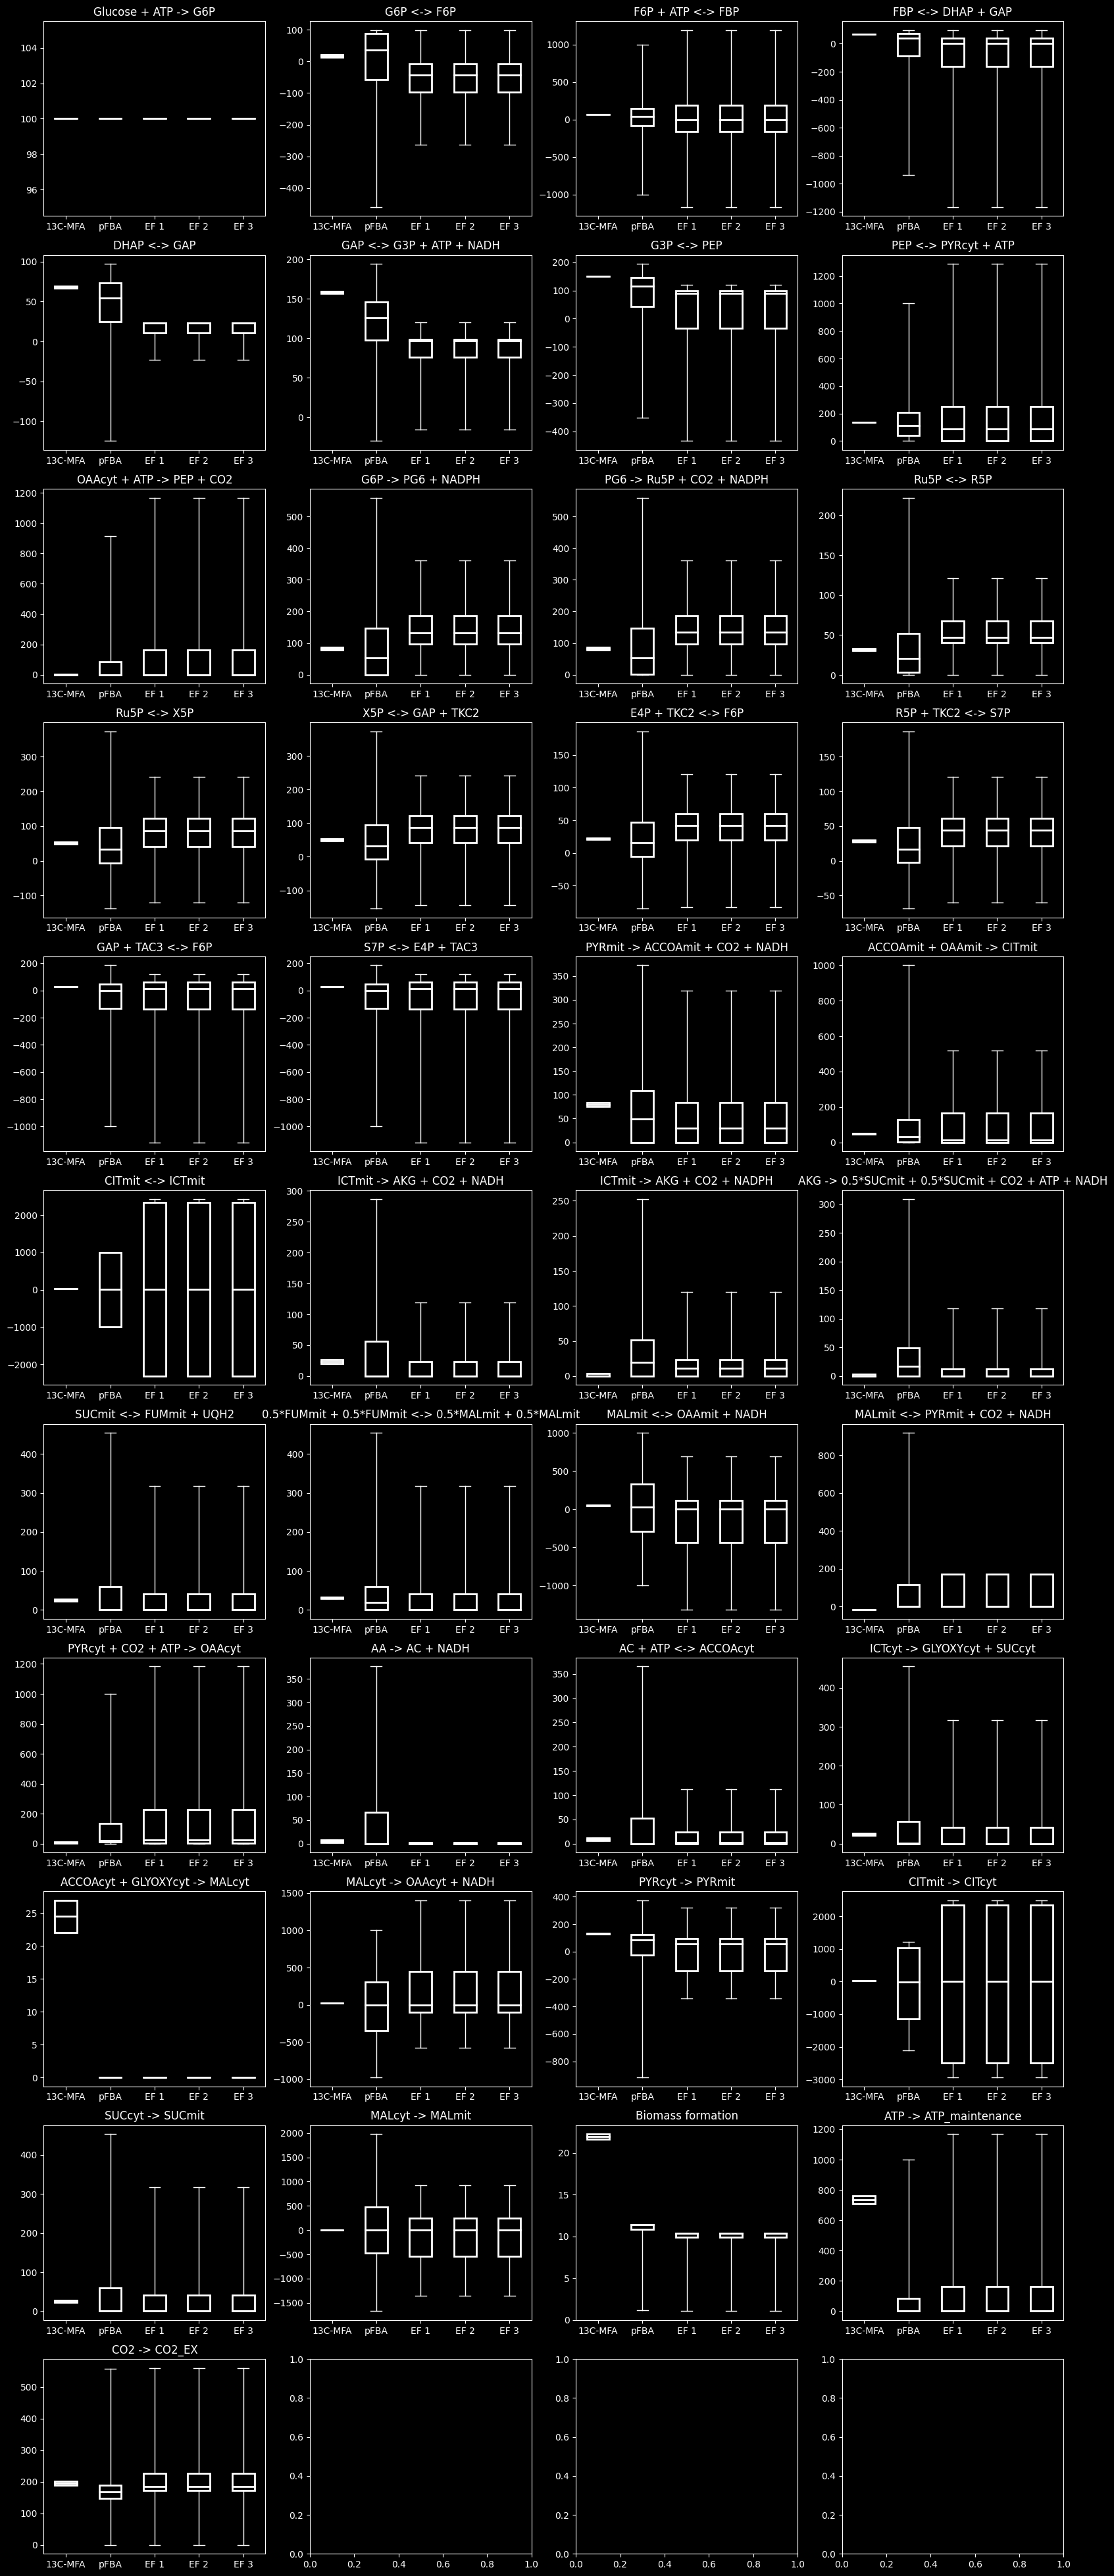

In [14]:
make_boxplot_grid(central_rxn_df, 'glucose')

# Glycerol

### Calculate glycerol GSM pFBA solution

In [ ]:
# update the media to minimal medium with glycerol as the sole carbon source
medium = model.medium
medium['EX_glc_e'] = 0
medium['EX_glyc_e'] = 100
medium['EX_ocdcea_e'] = 0
medium['EX_h2o_e'] = 10000
medium['EX_h_e'] = 10000
medium['EX_nh4_e'] = 10000
medium['EX_o2_e'] = 10000
medium['EX_pi_e'] = 10000
medium['EX_so4_e'] = 10000
medium['trehalose_c_tp'] = 0
model.medium = medium

# print the medium composition
[print(model.medium[m], m) for m in model.medium]

# run biomass-maximizing pFBA
glycerol_fba_solution = sd.fba(model, constraints='EX_glyc_e = -100.000', obj='biomass_C', obj_sense='maximize', pfba=1)
max_glycerol_biomass_flux = glycerol_fba_solution['biomass_C']
print(f'Maximum biomass flux: {max_glycerol_biomass_flux}.')
print(f'The number of active reactions in pFBA: {sum([abs(flux) > 0.1 for flux in glycerol_fba_solution.fluxes.values()])}')

# run pFBA FVA with 95% biomass flux constraint
glycerol_fva_95_solution = sd.fva(
  model, 
  constraints=f'EX_glyc_e = -100.000, biomass_C >= {0.95 * max_glycerol_biomass_flux}',
)
print(f'The number of active reactions in 95% biomass FVA: {sum([is_active_in_fva(row) for _, row in glycerol_fva_95_solution.iterrows()])}')

# run pFBA FVA with 10% biomass flux constraint
glycerol_fva_10_solution = sd.fva(
  model, 
  constraints=f'EX_glyc_e = -100.000, biomass_C >= {0.10 * max_glycerol_biomass_flux}',
)
print(f'The number of active reactions in 10% biomass FVA: {sum([is_active_in_fva(row) for _, row in glycerol_fva_10_solution.iterrows()])}')

# make a list of dictionaries with the reaction id, name, flux, and absolute flux
reactions = []
for reaction_id, flux in glycerol_fba_solution.fluxes.items():
  # add the reaction info to the list of dictionaries
  reactions.append({
    'reaction_id': reaction_id,
    'reaction_name': model.reactions.get_by_id(reaction_id).name,
    'full_reaction': model.reactions.get_by_id(reaction_id).reaction,
    'flux': flux,
    '95_LB': glycerol_fva_95_solution.loc[reaction_id, 'minimum'],
    '95_UB': glycerol_fva_95_solution.loc[reaction_id, 'maximum'],
    '10_LB': glycerol_fva_10_solution.loc[reaction_id, 'minimum'],
    '10_UB': glycerol_fva_10_solution.loc[reaction_id, 'maximum'],
    'absolute_flux': abs(flux), # use for sorting, then drop
  })

# make a dataframe from the list of dictionaries
glycerol_gsm_fba_df = pd.DataFrame(reactions)

# sort the dataframe by absolute flux
glycerol_gsm_fba_df = glycerol_gsm_fba_df.sort_values(by=['absolute_flux'], ascending=False)

# drop the absolute flux column
glycerol_gsm_fba_df = glycerol_gsm_fba_df.drop(columns=['absolute_flux'])

glycerol_gsm_fba_df.head()

### Add glycerol pFBA columns to 13C-MFA data

In [ ]:
# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, glycerol_gsm_fba_df, 'glycerol_pFBA_flux')

# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, glycerol_gsm_fba_df, 'glycerol', 'pFBA')

central_rxn_df.head()

### Plot glycerol MFA vs pFBA boxplots

In [ ]:
# make_boxplot_grid(central_rxn_df, 'glycerol')
make_boxplot_grid(central_rxn_df, 'glycerol', 'pFBA')

# Oleic Acid

### Calculate oleic acid GSM pFBA solution

In [ ]:
# update the media to minimal medium with oleic_acid as the sole carbon source
medium = model.medium
medium['EX_glc_e'] = 0
medium['EX_glyc_e'] = 0
medium['EX_ocdcea_e'] = 10 # this is prevent overflow
medium['EX_h2o_e'] = 10000
medium['EX_h_e'] = 10000
medium['EX_nh4_e'] = 10000
medium['EX_o2_e'] = 10000
medium['EX_pi_e'] = 10000
medium['EX_so4_e'] = 10000
medium['trehalose_c_tp'] = 0
model.medium = medium

# print the medium composition
[print(model.medium[m], m) for m in model.medium]

# run biomass-maximizing pFBA
oleic_acid_fba_solution = sd.fba(model, constraints='EX_ocdcea_e = -10', obj='biomass_C', obj_sense='maximize', pfba=1)
max_oleic_acid_biomass_flux = oleic_acid_fba_solution['biomass_C']
print(f'Maximum biomass flux: {max_oleic_acid_biomass_flux}.')
print(f'The number of active reactions in pFBA: {sum([abs(flux) > 0.1 for flux in oleic_acid_fba_solution.fluxes.values()])}')

# run pFBA FVA with 95% biomass flux constraint
oleic_acid_fva_95_solution = sd.fva(
  model, 
  constraints=f'EX_ocdcea_e = -10, biomass_C >= {0.95 * max_oleic_acid_biomass_flux}',
)
print(f'The number of active reactions in 95% biomass FVA: {sum([is_active_in_fva(row) for _, row in oleic_acid_fva_95_solution.iterrows()])}')

# run pFBA FVA with 10% biomass flux constraint
oleic_acid_fva_10_solution = sd.fva(
  model, 
  constraints=f'EX_ocdcea_e = -10, biomass_C >= {0.10 * max_oleic_acid_biomass_flux}',
)
print(f'The number of active reactions in 10% biomass FVA: {sum([is_active_in_fva(row) for _, row in oleic_acid_fva_10_solution.iterrows()])}')

# make a list of dictionaries with the reaction id, name, flux, and absolute flux
reactions = []
for reaction_id, flux in oleic_acid_fba_solution.fluxes.items():
  # add the reaction info to the list of dictionaries
  reactions.append({
    'reaction_id': reaction_id,
    'reaction_name': model.reactions.get_by_id(reaction_id).name,
    'full_reaction': model.reactions.get_by_id(reaction_id).reaction,
    'flux': 10 * flux,
    '95_LB': 10 * oleic_acid_fva_95_solution.loc[reaction_id, 'minimum'],
    '95_UB': 10 * oleic_acid_fva_95_solution.loc[reaction_id, 'maximum'],
    '10_LB': 10 * oleic_acid_fva_10_solution.loc[reaction_id, 'minimum'],
    '10_UB': 10 * oleic_acid_fva_10_solution.loc[reaction_id, 'maximum'],
    'absolute_flux': 10 * abs(flux), # use for sorting, then drop
  })

# make a dataframe from the list of dictionaries
oleic_acid_gsm_fba_df = pd.DataFrame(reactions)

# sort the dataframe by absolute flux
oleic_acid_gsm_fba_df = oleic_acid_gsm_fba_df.sort_values(by=['absolute_flux'], ascending=False)

# drop the absolute flux column
oleic_acid_gsm_fba_df = oleic_acid_gsm_fba_df.drop(columns=['absolute_flux'])

oleic_acid_gsm_fba_df.head()

### Add oleic acid pFBA columns to 13C-MFA data

In [ ]:
# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, oleic_acid_gsm_fba_df, 'oleic_acid_pFBA_flux')

# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, oleic_acid_gsm_fba_df, 'oleic_acid', 'pFBA')

central_rxn_df.head()

### Plot oleic acid MFA vs pFBA boxplots

In [ ]:
make_boxplot_grid(central_rxn_df, 'oleic_acid', 'pFBA')

# Save Data

### Save central flux data with pFBA data added

In [ ]:
# save the dataframe to a csv file
central_rxn_df.to_csv('../results/central_fluxes/pfba.csv', index=False, encoding='utf-8-sig')